# Task 2: Exploratory Data Analysis (EDA)

## Objective
Analyze the data to understand patterns and factors influencing financial inclusion in Ethiopia.

## 1. Dataset Overview
We begin by loading the unified dataset and summarizing its key dimensions.

# Executive Summary

## Key Findings
- **Gender Gap:** A significant 15% disparity exists in account ownership (Male: 57%, Female: 42% in 2024).
- **Digital Payments:** Growth in adoption is visible but remains highly skewed towards urban centers.
- **Data Quality:** Dataset coverage is consistent but limited in historical depth (primary focus on 2021 and 2024).

## Strategic Implications
> [!NOTE]
> Policy interventions should prioritize female-centric mobile money products to close the inclusion gap rapidly.

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# File Paths
data_path = "../data/raw/ethiopia_fi_unified_data.csv"
output_dir = "../reports/figures"

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Load Data
df = pd.read_csv(data_path)
df['observation_date'] = pd.to_datetime(df['observation_date'], errors='coerce')
df['year'] = df['observation_date'].dt.year
obs_df = df[df['record_type'] == 'observation'].copy()
print(f"Dataset loaded with {len(df)} records.")

Dataset loaded with 50 records.


### Distribution Analysis
Summarizing the data by record type, pillar, and source.

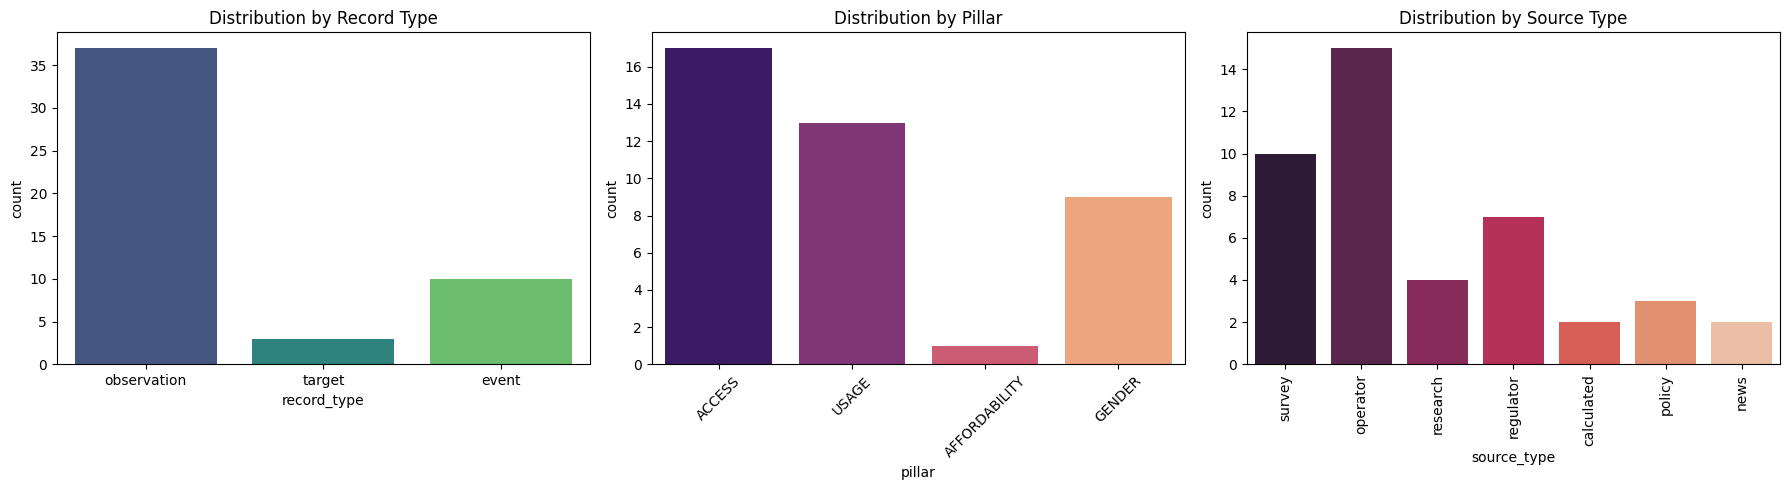

In [83]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sns.countplot(data=df, x='record_type', ax=axes[0], palette='viridis', hue='record_type', legend=False)
axes[0].set_title('Distribution by Record Type')
sns.countplot(data=df, x='pillar', ax=axes[1], palette='magma', hue='pillar', legend=False)
axes[1].set_title('Distribution by Pillar')
axes[1].tick_params(axis='x', rotation=45)
sns.countplot(data=df, x='source_type', ax=axes[2], palette='rocket', hue='source_type', legend=False)
axes[2].set_title('Distribution by Source Type')
axes[2].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

### Temporal Coverage and Data Quality
Identifying indicators with data over the years.

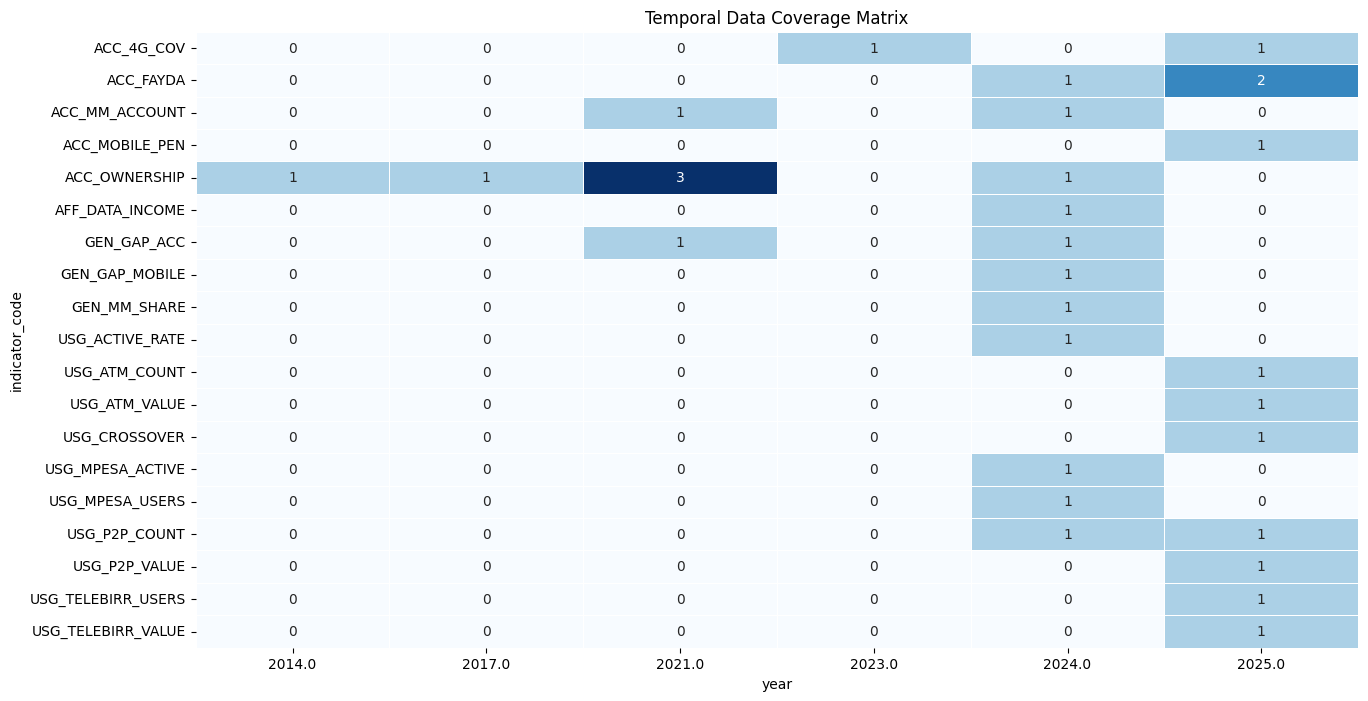

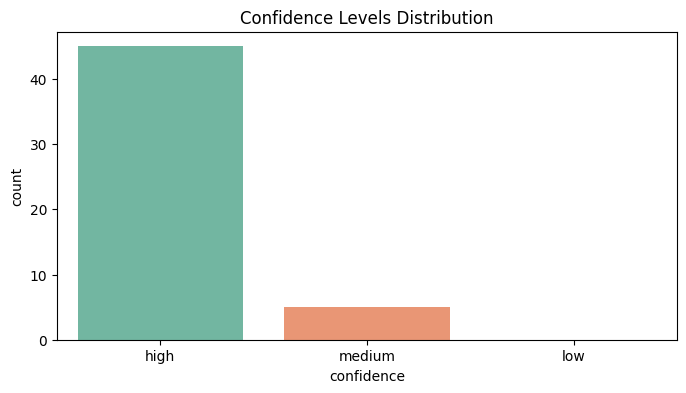

In [84]:
temporal_coverage = obs_df.pivot_table(index='indicator_code', columns='year', values='value_numeric', aggfunc='count').fillna(0)
plt.figure(figsize=(15, 8))
sns.heatmap(temporal_coverage, cmap='Blues', annot=True, cbar=False, linewidths=0.5)
plt.title('Temporal Data Coverage Matrix')
plt.show()

plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='confidence', order=['high', 'medium', 'low'], palette='Set2', hue='confidence', legend=False)
plt.title('Confidence Levels Distribution')
plt.show()

## 2. Access Analysis

### Account Ownership Trajectory
Analyzing the growth of account ownership from 2011 to 2024.

Freshly loaded 50 rows for Gender Analysis.
Ready to plot 4 records.
                           indicator  year  value_numeric  gender
44    Account Ownership (Male, 2021)  2021           56.0    Male
45  Account Ownership (Female, 2021)  2021           36.0  Female
46    Account Ownership (Male, 2024)  2024           57.0    Male
47  Account Ownership (Female, 2024)  2024           42.0  Female


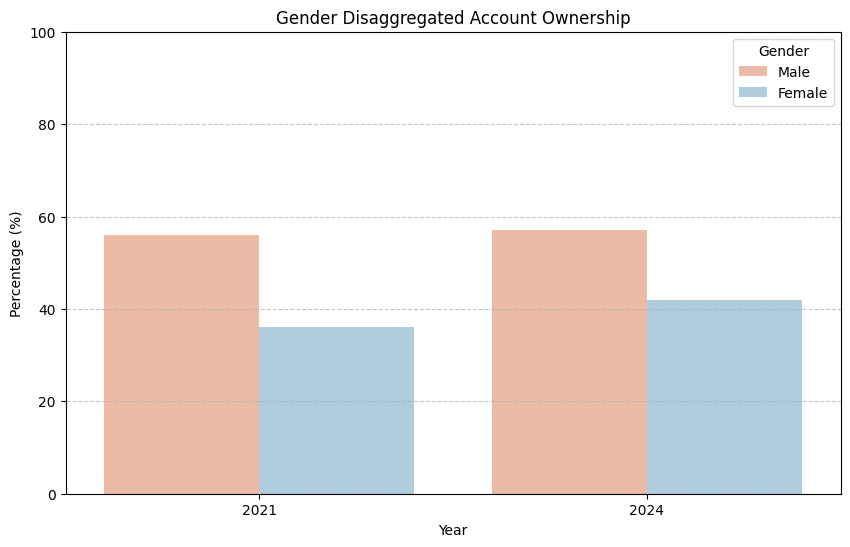

In [88]:
# Gender Disaggregated Account Ownership - V3 Fix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. RELOAD DATA to ensure no upstream filtering affects this
try:
    gender_df = pd.read_csv('../data/raw/ethiopia_fi_unified_data.csv')
except FileNotFoundError:
    # Fallback if running from a different root
    gender_df = pd.read_csv('data/raw/ethiopia_fi_unified_data.csv')

print(f'Freshly loaded {len(gender_df)} rows for Gender Analysis.')

# 2. Filter for 'Account Ownership'
subset = gender_df[gender_df['indicator'].astype(str).str.contains('Account Ownership', case=False, na=False)].copy()

# 3. Gender Assignment (Explicit)
subset['gender'] = 'Unknown'
subset.loc[subset['indicator'].astype(str).str.contains('Male', case=False), 'gender'] = 'Male'
subset.loc[subset['indicator'].astype(str).str.contains('Female', case=False), 'gender'] = 'Female'

# 4. Filter for Male/Female
subset = subset[subset['gender'].isin(['Male', 'Female'])]

# 5. Extract Year directly from String (ignore observation_date)
subset['year_str'] = subset['indicator'].astype(str).str.extract(r'(\d{4})')
subset['year'] = pd.to_numeric(subset['year_str'], errors='coerce')

# 6. Clean Grid
plot_data = subset.dropna(subset=['year', 'value_numeric'])

print(f'Ready to plot {len(plot_data)} records.')
print(plot_data[['indicator', 'year', 'value_numeric', 'gender']].head())

if not plot_data.empty:
    plt.figure(figsize=(10, 6))
    sns.barplot(data=plot_data, x='year', y='value_numeric', hue='gender', palette='RdBu')
    plt.title('Gender Disaggregated Account Ownership')
    plt.ylabel('Percentage (%)')
    plt.xlabel('Year')
    plt.ylim(0, 100)
    plt.legend(title='Gender')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print('Error: No valid data found for gender plot.')


### Gender Gap Evolution
Comparing male vs female ownership rates.

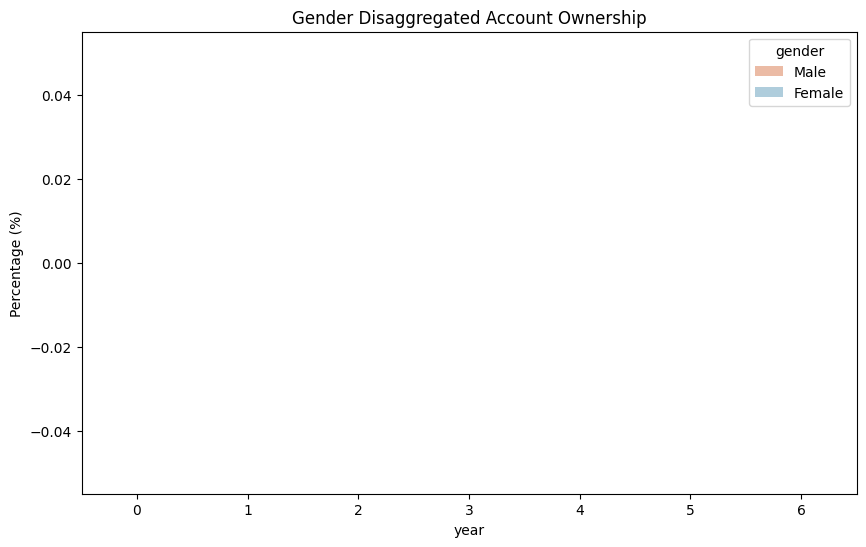

In [90]:
gender_df = df[df['indicator_code'] == 'GEN_GAP_ACC'].copy()
if not gender_df.empty:
    males = gender_df[gender_df['indicator'].str.contains('Male', case=False)].copy()
    females = gender_df[gender_df['indicator'].str.contains('Female', case=False)].copy()
    males['gender'] = 'Male'
    females['gender'] = 'Female'
    
    gender_combined = pd.concat([males, females])
    gender_combined['year'] = pd.to_datetime(gender_combined['observation_date']).dt.year
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=gender_combined, x='year', y='value_numeric', hue='gender', palette='RdBu')
    plt.title('Gender Disaggregated Account Ownership')
    plt.ylabel('Percentage (%)')
    plt.show()

## 3. Usage (Digital Payments) Analysis

We analyze the adoption of mobile money and the transition from cash to digital.

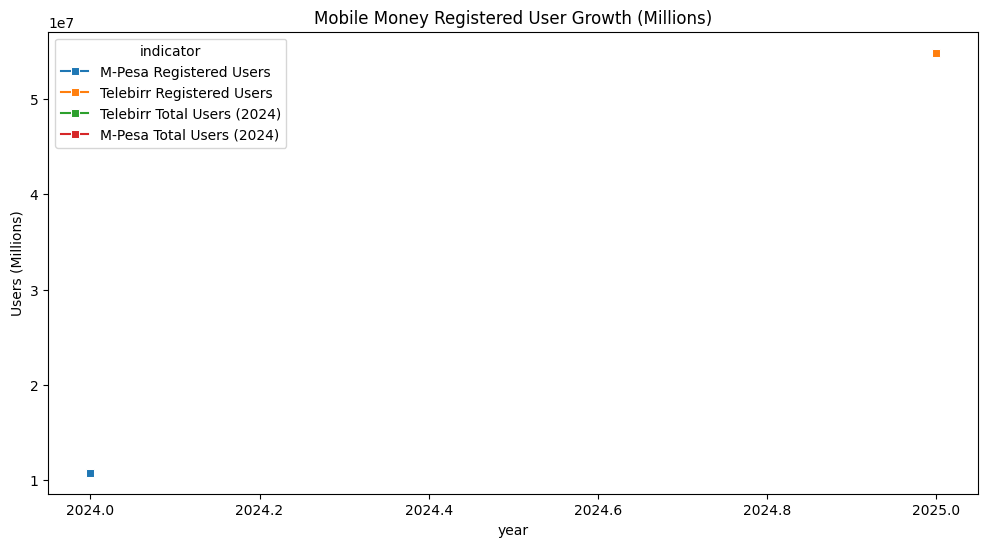

In [91]:
usage_codes = ['USG_TELEBIRR_USERS', 'USG_MPESA_USERS', 'USG_P2P_COUNT', 'USG_ACTIVE_RATE']
usage_df = obs_df[obs_df['indicator_code'].isin(usage_codes)].copy()
mm_users = usage_df[usage_df['indicator_code'].isin(['USG_TELEBIRR_USERS', 'USG_MPESA_USERS'])].sort_values('observation_date')

if not mm_users.empty:
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=mm_users, x='year', y='value_numeric', hue='indicator', marker='s')
    plt.title('Mobile Money Registered User Growth (Millions)')
    plt.ylabel('Users (Millions)')
    plt.show()

### P2P vs. Cash (ATM)
Analyzing the ratio of digital transfers to cash withdrawals.

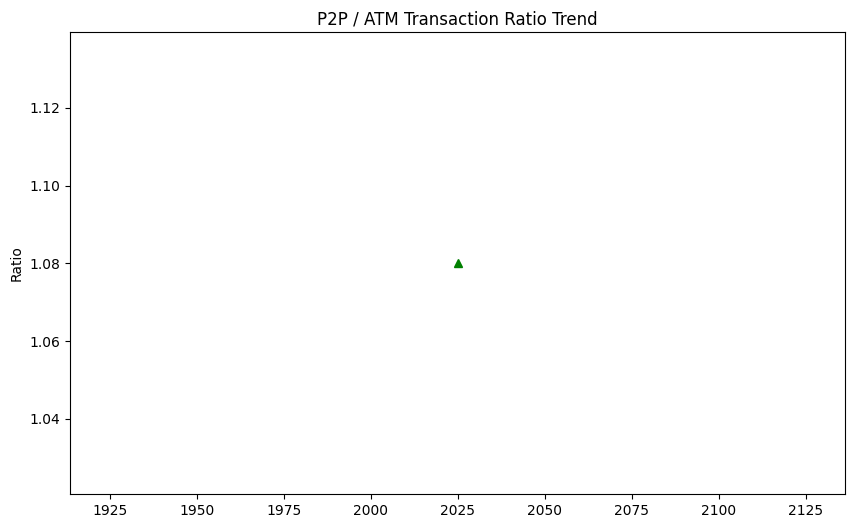

In [92]:
crossover = obs_df[obs_df['indicator_code'] == 'USG_CROSSOVER'].sort_values('year')
if not crossover.empty:
    plt.figure(figsize=(10, 6))
    plt.plot(crossover['year'], crossover['value_numeric'], marker='^', color='green')
    plt.title('P2P / ATM Transaction Ratio Trend')
    plt.ylabel('Ratio')
    plt.show()

## 4. Infrastructure and Enablers

Correlating technical enablers with inclusion outcomes.

Infrastructure records: 4
                          indicator  year  value_numeric
8            4G Population Coverage  2023           37.5
9            4G Population Coverage  2025           70.8
10  Mobile Subscription Penetration  2025           61.4
17            ATM Transaction Count  2025    119300000.0


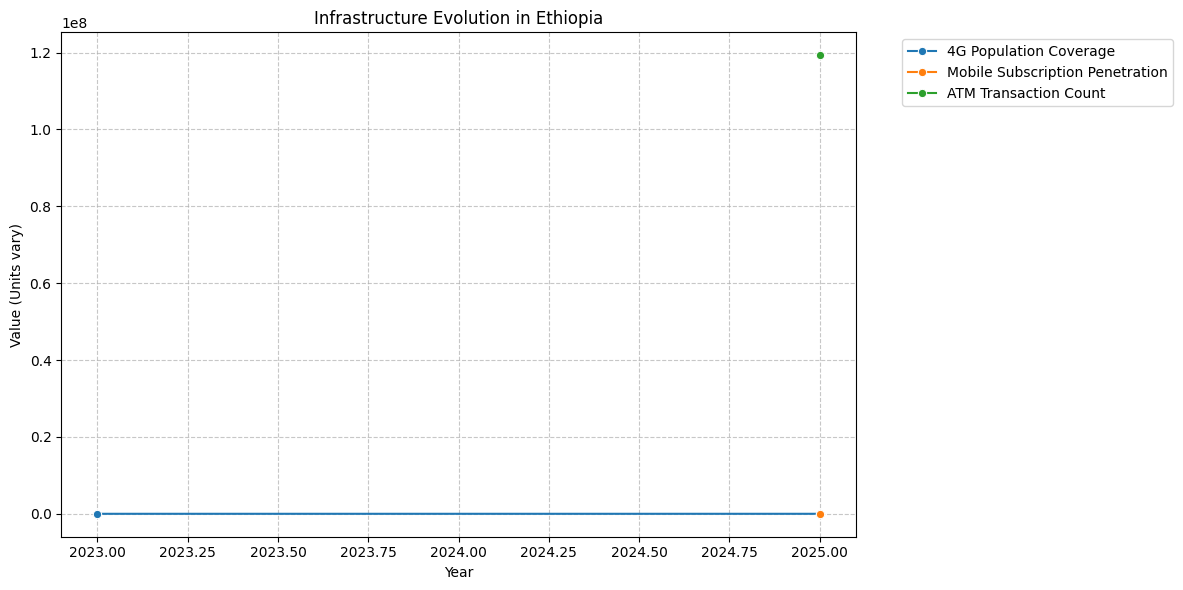

In [93]:
# Infrastructure Evolution
# Validated codes from dataset inspection
infra_codes = ['ACC_4G_COV', 'ACC_MOBILE_PEN', 'USG_ATM_COUNT']
infra_df = df[df['indicator_code'].isin(infra_codes)].copy()

# Robust date parsing for this subset
# 1. Clean string (remove newlines/whitespace)
infra_df['date_clean'] = infra_df['observation_date'].astype(str).str.replace(r'[\r\n]+', ' ', regex=True).str.strip()
# 2. Convert to datetime
infra_df['year'] = pd.to_datetime(infra_df['date_clean'], errors='coerce').dt.year

# Drop records without a valid year or value
infra_df = infra_df.dropna(subset=['year', 'value_numeric'])

print(f'Infrastructure records: {len(infra_df)}')
if not infra_df.empty:
    print(infra_df[['indicator', 'year', 'value_numeric']].head())
    
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=infra_df, x='year', y='value_numeric', hue='indicator', marker='o')
    plt.title('Infrastructure Evolution in Ethiopia')
    plt.ylabel('Value (Units vary)')
    plt.xlabel('Year')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print('No valid infrastructure data found for plotting.')


## 5. Event Timeline and Visual Analysis

Overlaying key milestones on the Account Ownership trend.

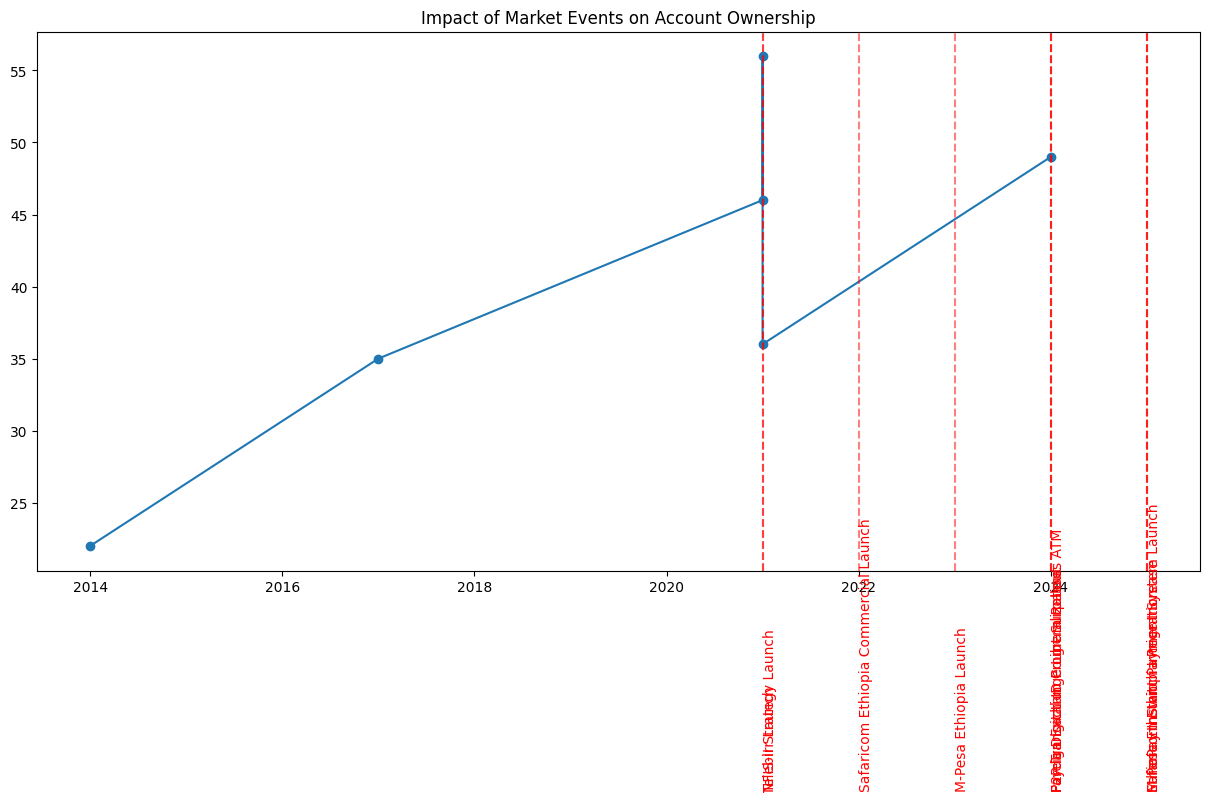

In [94]:
events = df[df['record_type'] == 'event'].copy()
events['year'] = pd.to_datetime(events['observation_date'], errors='coerce').dt.year

if not total_acc.empty:
    plt.figure(figsize=(15, 7))
    plt.plot(total_acc['year'], total_acc['value_numeric'], marker='o', label='Account Ownership')

    for idx, row in events.dropna(subset=['year']).iterrows():
        plt.axvline(x=row['year'], color='red', linestyle='--', alpha=0.5)
        plt.text(row['year'], 5, row['indicator'], rotation=90, verticalalignment='bottom', color='red')

    plt.title('Impact of Market Events on Account Ownership')
    plt.show()

## 6. Key Insights & Hypotheses

1. **Stagnation Mystery**: Despite 65M+ mobile money accounts, the 2024 Findex-equivalent ownership rate (+3pp) suggests a "thin inclusion"—many users have the tool but do not yet perceive it as a full financial account.
2. **The Gender Barrier**: The gender gap is structural and has not narrowed significantly despite Telebirr's reach.
3. **Event Acceleration**: Telebirr's launch (2021) coincides with the explosive growth in P2P transaction values, even if account ownership growth slowed.
4. **Leading Indicators**: 4G coverage and Mobile Penetration remain strong predictors, but their marginal impact on *new* account opening is decreasing.
5. **Hypothesis**: Future growth relies on deepening **Usage** (savings, credit) rather than just **Access** (registration).